In [ ]:
import time
import re
import sys
import numpy as np
np.random.seed(2021)

"""

Nos comentários utilizaremos o id do usuário para definir o valor que aparece no arquivo de ratings
O índice do usuário é a linha na matriz (de ratings) que o usuário está
Raciocínio análogo para os itens

Operações vetorizadas são muito rápidas, 
porém como os dados são extremamente esparsos a computação vetorizada não foi ""eficiente""

Computamos os elementos usuários mais similares e armazenos em um vetor ordenado
Para facilitar a seleção dos top-k neighboors
Priority Queue(ou heapq) - binary heap - O(logn) - Worst-case Time Complexity - insertion (nlogn)

"""


# TODO bbb

# warnings.filterwarnings('ignore')

def readFile(name_file, type="train", ignore_first_line=True, users_to_add=None, items_to_add=None,
             intersect_or_union='intersect', type_return='dict'):
    """
    Essa função lê um arquivo de usuários itens, com ou sem ratings e timestamp
    Para arquivos do tipo train é retornado um set com os usuários, um set com os itens, e um terceiro retorno
    Se type_return for 'dict' o terceiro retorno é um dicionário com chaves para usuários, e cada usuário contém
    um dicionário para seus itens e cada item indexa o rating do usuário chave para tal item
    Se type_return for 'array' o terceiro retorno é um array com pares de user,item (type == test) ou trios de
    user,item,rating (type == train)

    Parameters
    ----------
    name_file : str
        O nome do arquivo a ser lido.

    type : {'train', 'test'}, optional
        O tipo do arquivo a ser lido.
            Se 'train' cada linha do arquivo deve ter o formato u{user_id}:i{item_id},{rating},{timestamp}
            Se 'test' cada linha do arquivo deve ter o formato u{user_id}:i{item_id}

    ignore_first_line : boolean, optional
        Se True ignora a primeira linha do arquivo a ser lido

    users_to_add: set or dict, optional
        Se esse parâmetro for utilizado observe também os parâmetros items_to_add e intersect_or_union
        A saída irá conter apenas usuários em users_to_add
            Pode conter usuários que não estão em users_to_add se (items_to_add != None & intersect_or_union == 'union')

    items_to_add: set or dict, optional
        Se esse parâmetro for utilizado observe também os parâmetros items_to_add e intersect_or_union
        A saída irá conter apenas itens em items_to_add
            Pode conter itens que não estão em items_to_add se (users_to_add != None & intersect_or_union == 'union')

    intersect_or_union : {'intersect', 'union'}, optional
        Esse parâmetro só é utilizado quando users_to_add e items_to_add são ambos não nulos
        Se 'intersect' a saída ignora as linhas com usuários que não estão em users_to_add & ignora as linhas com itens que
            não estão em items_to_add.
        Se 'union' a saída ignora as linhas com usuários que não estão em users_to_add a menos que o item da linha
            contenha algum item em items_to_add. Ignora também as linhas com items que não estão em items_to_add a menos
            que o usuário da linha contenha algum usuário em users_to_add.

    type_return : {'array', 'dict'}, optional
        Esse parâmetro indica se o terceiro item do retorno é um array ou um dicionário
        Se type_return for 'dict' o terceiro retorno é um dicionário com chaves para usuários, e cada usuário contém
        um dicionário para seus itens e cada item indexa o rating do usuário chave para tal item
        Se type_return for 'array' o terceiro retorno é um array com pares de user,item (type == test) ou trios de
        user,item,rating (type == train)

    """

    with open(name_file, 'r') as file:
        lines = file.readlines()

    if ignore_first_line:
        lines = lines[1:]

    if type == "test":
        p = re.compile('u([0-9]*):i([0-9]*)')
    elif type == "train":
        p = re.compile('u([0-9]*):i([0-9]*),([0-9]*),([0-9]*)')
    else:
        raise Exception("Invalid type of file")

    all_users = set()
    all_items = set()

    users_items_map = {}

    cont_removed_ratings = 0

    add_all = users_to_add is None and items_to_add is None
    add_by_items = users_to_add is None and not items_to_add is None
    add_by_users = not users_to_add is None and items_to_add is None

    array_user_item_pairs = []

    for line in lines:
        m = p.match(line)

        u = int(m.groups()[0])
        i = int(m.groups()[1])

        if type == "test":
            r = 0
        else:
            r = int(m.groups()[2])

        all_users.add(u)
        all_items.add(i)

        should_be_added = False
        if add_all:
            should_be_added = True
        elif add_by_items and add_by_users:
            if intersect_or_union == 'intersect':
                if u in users_to_add and i in items_to_add:
                    should_be_added = True
            if intersect_or_union == 'union':
                if u in users_to_add or i in items_to_add:
                    should_be_added = True
        elif add_by_users:
            if u in users_to_add:
                should_be_added = True
        elif add_by_items:
            if i in items_to_add:
                should_be_added = True

        if should_be_added:
            if type_return == 'array' and type == 'train':
                array_user_item_pairs.append((u, i, r))
            elif type_return == 'array' and type == 'test':
                array_user_item_pairs.append((u, i))
            else:
                users_items_map.setdefault(u, {})
                users_items_map[u].setdefault(i, r)
        else:
            cont_removed_ratings += 1

    # print(f"{cont_removed_ratings} removed ratings")
    if type_return == 'array':
        return all_users, all_items, array_user_item_pairs
    return all_users, all_items, users_items_map


"""
Lemos os arquivos de treino e teste de uma só vez para garantir que todos os usuários e itens da coleção estarão
na matriz de ratings

TODO regularization SGD
"""


def indexTwoSets(first_set, second_set) -> (dict, dict):
    """
    Retorna a indexação dos dados nos conjuntos first_set e second_set (essa indexação pode ser utilizada para acessar a
    posição de um elemento do conjunto em um vetor indexado a partir de zero

    Parameters
    ----------
    first_set: set or dict
        É um conjunto de dados únicos
    second_set: set or dict
        É um conjunto de dados únicos

    Returns
    -------
        indexes, not_in_first_set
        indexes:
            Junta os dados do first_set com o second_set, e para cada item única desse conjunto é assinalado um índice
        not_in_first_set: dict
            Contém as chaves que estão no second_set mas não no first_set

    """

    indexes = {}
    count = 0
    for u in first_set:
        if u not in indexes:
            indexes.setdefault(u, count)
            count += 1

    not_in_first_set = {}
    for u in second_set:
        if u not in indexes:
            indexes.setdefault(u, count)
            count += 1
            not_in_first_set.setdefault(u, 0)

    return indexes, not_in_first_set


def createMatrixRatings(all_users_test, all_items_test, all_users_train, all_items_train,
                        users_itens_map_train, default_value=0) -> (dict, dict, np.array, np.array):
    """
    Retorna a indexação de todos os usuários em all_users_test e all_users_train, assim como indexa todos os itens
    em all_items_test e all_items_train na matriz de ratings (np.array bidimensional) que também é retornada

    Parameters
    ----------
    all_users_test: set or dict
        É um conjunto de usuários, é necessário pois não seria possível fazer uma predição para esse usuário se ele não
        estiver na matriz de ratings (mesmo que ele não tenha feito nenhum rating no traino)
    all_items_test: set or dict
        É um conjunto de itens, é necessário pois não seria possível fazer uma predição desse item para um usuário se
        ele não estiver na matriz de ratings (mesmo que ele não tenha recebido nenhum rating no traino)
    all_users_train: set or dict
        É o conjunto de usuários em users_itens_map_train
    all_items_train: set or dict
        É o conjunto de items em users_itens_map_train
    users_itens_map_train: dict
        Contém ratings de usuários para itens: As chaves iniciais são usuários, e cada usuário contém um dicionário
        para seus itens, e cada item indexa o rating do usuário chave para tal item
    default_value: float
        É o valor padrão dos ratings na matriz retornada para os pares de (usuário, item) que não tem rating

    Returns
    -------
        indexes_users, indexes_items, ratings, bool_ratings
        indexes_users:
            É um dicionário com a união das chaves em all_users_train e all_users_test, e mapeia o índice desse usuário
            na matriz de ratings (é um índice de uma linha da matriz)
        indexes_items:
            É um dicionário com a união das chaves em all_items_train e all_items_test, e mapeia o índice desse item
            na matriz de ratings (é um índice de uma coluna da matriz)
        ratings:
            É um np.array bidimensinal onde cada linha é um usuário (de all_users_train e all_users_test)
            e cada coluna um item de (de all_items_train e all_items_test), com valor padrão definido em default_value,
            e com os valores dos ratings de users_itens_map_train
        bool_ratings:
            É um np.array bidimensinal onde cada linha é um usuário (de all_users_train e all_users_test)
            e cada coluna um item de (de all_items_train e all_items_test), com valor padrão 0,
            e onde há ratings em users_itens_map_train o valor é 1 (apenas para diferenciar um rating 0 do valor default 0)

    """

    indexes_users = indexTwoSets(all_users_train, all_users_test)
    user_count = len(indexes_users)

    indexes_items = indexTwoSets(all_items_test, all_items_train)
    item_count = len(indexes_items)

    ratings = np.zeros((user_count, item_count), dtype=np.float) + default_value
    bool_ratings = np.zeros((user_count, item_count), dtype=np.float)
    # i_bool_ratings = np.ones((user_count, item_count), dtype=np.float)

    for u in users_itens_map_train:
        for i in users_itens_map_train[u]:
            ratings[indexes_users[u]][indexes_items[i]] = users_itens_map_train[u][i]
            bool_ratings[indexes_users[u]][indexes_items[i]] = 1
            # i_bool_ratings[indexes_users[u]][indexes_items[i]] = 0

    return indexes_users, indexes_items, ratings, bool_ratings


def computMeanCenteringNormalization(ratings, bool_ratings):
    """

    Parameters
    ----------
    ratings: np.array
        Matriz de ratings (cada linha é um usuário e cada coluna um item)
    bool_ratings: np.array
        Matriz boolean de ratings (cada linha é um usuário e cada coluna um item),
        É utilizada para diferenciar um rating 0 de um valor 0 na matriz que é a ausência de rating
    Returns
    -------
        Retorna uma matriz do mesmo tamanho das matriz de entrada, após fazer o cálculo da normalização central de rating
    """
    users_mean_rating = np.sum(ratings, axis=1) / np.sum(bool_ratings, axis=1)
    np.nan_to_num(users_mean_rating, copy=False)
    num_items = ratings.shape[1]
    return ratings - np.multiply(bool_ratings, np.tile(users_mean_rating, (num_items, 1)).T)


def computeCosineSimilarity(user_index, ratings):
    """

    Parameters
    ----------
    user_index: int
        Índice do usuário na matriz de ratings para o qual queremos calcular a similaridade com os demais usuários da matriz
    ratings: np.array
        Matriz de ratings (cada linha é um usuário e cada coluna um item)

    Returns
    -------
        Retorna um np.array com tamanho igual ao número de linhas da matriz de ratings, onde cada valor desse vetor é
        a similaridade do cosseno usuário dessa linha na matriz com o usuário do índice passado em user_index
    """
    all_similarities = np.sum(ratings[user_index] * ratings, axis=1) / (np.sqrt(np.sum(
        ratings[user_index] * ratings[user_index])) * np.sqrt(np.sum(np.multiply(ratings, ratings), axis=1)))
    return all_similarities


class SGD:
    """

    """

    def __init__(self, alpha=0.001, num_iteracoes=50, num_latent_factor=5, lambda_reg=0):
        """

        Parameters
        ----------
        alpha: float Taxa de aprendizado do SGD
        num_iteracoes: int Quantidade de iterações performadas (cada iteração ajusta cada um dos ratings em users_items_map_train
        num_latent_factor: int número de fatores latentes que serão estimados
        lambda_reg: float regularaização do erro - to avoid overfitting
        """
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        self.num_iteracoes = num_iteracoes
        self.num_latent_factor = num_latent_factor
        self.P = []
        self.Q = []

    def fit(self, users_items_map_train, indexes_users, indexes_items):
        """

        Parameters
        ----------
        users_items_map_train: dict of dicts dicionário de usuários, onde cada usuário tem um dicionário de itens mapeando
            o rating desse usuário para esse item
        indexes_users: dict Dicionário com todos os usuários que serão utilizados para construir as matrizes de fatores
            latentes (pode conter users not in users_items_map_train)
        indexes_items: dict Dicionário com todos os itens que serão utilizados para construir as matrizes de fatores
            latentes (pode conter items not in users_items_map_train)

        Returns
        -------
        Retorna as matrizes P e Q que são representações aproximadas da matriz de ratings

        """
        num_users = len(indexes_users)
        num_items = len(indexes_items)

        self.P = np.ones((num_users, self.num_latent_factor), dtype=np.float)
        self.Q = np.ones((self.num_latent_factor, num_items), dtype=np.float)

        user_keys = np.array(list(users_items_map_train.keys()))

        for iter in range(self.num_iteracoes):
            np.random.shuffle(user_keys)
            for u in user_keys:
                # for u in users_items_map_train:
                for i in users_items_map_train[u]:
                    eui = users_items_map_train[u][i] - np.sum(
                        (self.P[indexes_users[u]]) * (self.Q[:, indexes_items[i]]))

                    # P[indexes_users[u]] = P[indexes_users[u]] + 2 * alpha * eui * Q[:, indexes_items[i]]
                    # Q[:, indexes_items[i]] = Q[:, indexes_items[i]] + 2 * alpha * eui * P[indexes_users[u]]

                    rP = self.P[indexes_users[u]] + 2 * self.alpha * eui * self.Q[:,indexes_items[i]] - 2 * self.alpha * self.lambda_reg * \
                         self.P[indexes_users[u]]

                    stop = False
                    if np.isnan(rP).any():
                        stop = True

                    rQ = self.Q[:, indexes_items[i]] + 2 * self.alpha * eui * rP - 2 * self.alpha * self.lambda_reg * \
                         - 2 * self.alpha * self.lambda_reg * self.Q[:,indexes_items[i]]

                    if np.isnan(rQ).any():
                        stop = True

                    # O método pode divergir para valores muito grandes de alpha
                    if not stop:
                        self.P[indexes_users[u]] = rP
                        self.Q[:, indexes_items[i]] = rQ
                    else:
                        return self.P, self.Q
        return self.P, self.Q

    def predict(self, users_itens, indexes_users, indexes_items, users_without_rating=None,
                type_of_predict_for_users_without_rating='default'):
        """

        Parameters
        ----------
        users_itens: array of (u, i) para ser computado o rating do user u para o item i
        indexes_users: dict Dicionário com todos os usuários que serão utilizados para construir as matrizes de fatores
            latentes (pode conter users not in users_items_map_train) - contém os índices dos usuários na matriz de fator latente
        indexes_items: dict Dicionário com todos os itens que serão utilizados para construir as matrizes de fatores
            latentes (pode conter items not in users_items_map_train) - contém os índices dos itens na matriz de fator latente
        users_without_rating: dict Dicionário com todos os usuários que não possuem ratings no conjunto de treino (fit function)
            Para esses usuários o rating para um item i pode ser a média de ratings desse item i, a média global de ratings,
            ou o valor da decomposição SGD - que é especificado no parâmetro type_of_predict_for_users_without_rating
        type_of_predict_for_users_without_rating: {'mean_item', 'global_mean', 'default'}, optional
            mean_item - Para usuários do conjunto users_without_rating o rating computado para um item i é a média dos ratings do item i
            global_mean - Para usuários do conjunto users_without_rating o rating computado para um item i é a média global dos ratings
            default - Utiliza a decomposição do SGD para gerar todos os ratings
        Returns
        -------
             Retorna um array de ratings para cada par (u, i) em users_itens
        """

        if not users_without_rating is None:
            print("inside")
            result = np.matmul(self.P, self.Q)
            mean_item = np.mean(result, axis=0)
            global_mean = np.mean(mean_item)
        else:
            users_without_rating = {}
            result = None

        predicts = np.zeros(len(users_itens), dtype=np.float)
        cont = 0

        if users_without_rating is None:
            users_without_rating = {}

        # for (u, i) in users_itens:
        for (u, i, r) in users_itens:
            if u in users_without_rating:
                if type_of_predict_for_users_without_rating == 'mean_item':
                    predicts[cont] = mean_item[indexes_items[i]]
                elif type_of_predict_for_users_without_rating == 'global_mean':
                    predicts[cont] = global_mean
                else:
                    predicts[cont] = result[indexes_users[u]][indexes_items[i]]
                #
            else:
                if result is None:
                    predicts[cont] = np.matmul(self.P[indexes_users[u]], self.Q[:, indexes_items[i]])
                else:
                    predicts[cont] = result[indexes_users[u]][indexes_items[i]]
            cont += 1
        return predicts


def writePredict(name_file_output, users_itens, predicts, header="UserId:ItemId,Prediction", verbose=False):
    """

    Parameters
    ----------
    name_file_output: str Nome do arquivo de saída
    users_itens: array de pares (u, i)
    predicts: array de ratings preditos para todos os pares (u, i)
    header: str Cabeçalho do arquivo de saída
    verbose: bool Escreve as predições na saída padrão

    Returns
    -------

    """
    if verbose:
        for u_i, p in zip(users_itens, predicts):
            u = u_i[0]
            i = u_i[1]
            print("u" + str(u).zfill(7) + ":" + "i" + str(i).zfill(7) + "," + str(p))
    else:
        with open(name_file_output, 'w') as file:
            file.write(header + "\n")
            for u_i, p in zip(users_itens, predicts):
                u = u_i[0]
                i = u_i[1]
                file.write("u" + str(u).zfill(7) + ":" + "i" + str(i).zfill(7) + "," + str(p) + "\n")

In [ ]:
import random
import numpy as np
import os
os.mkdir('fold')
u, i, u_i_r = readFile("ratings.csv", type="train", type_return="array")

size_pop = len(u_i_r)
size_pop10 = int(0.1 * len(u_i_r))

for f in range(5):
    r = random.sample(range(size_pop), size_pop10)
    r = np.sort(r)

    cp = 0
    cs10 = 0
    with open(f"fold/ratings-{f}.csv", 'w') as fp:
        with open(f"fold/targets-{f}.csv", 'w') as fs10:
            fp.write("bl\n")
            fs10.write("bl\n")
            for i in range(size_pop):
                if cs10 < size_pop10:
                    if r[cs10] == i:
                        fs10.write("u" + str(u_i_r[i][0]).zfill(7) + ":" + "i" + str(u_i_r[i][1]).zfill(7) + "," + str(
                            u_i_r[i][2]) + ",1421526527" + "\n")
                        cs10 += 1
                    else:
                        fp.write("u" + str(u_i_r[i][0]).zfill(7) + ":" + "i" + str(u_i_r[i][1]).zfill(7) + "," + str(
                            u_i_r[i][2]) + ",1421526527" + "\n")

                        cp += 1
                else:
                    fp.write("u" + str(u_i_r[i][0]).zfill(7) + ":" + "i" + str(u_i_r[i][1]).zfill(7) + "," + str(
                        u_i_r[i][2]) + ",1421526527" + "\n")

                    cp += 1


In [ ]:
start = time.time()

# all_users_predict, all_items_predict, users_items_array_to_predict = readFile(sys.argv[2], type="test",
#                                                                               type_return="array")
# all_users_train, all_items_train, users_items_map_train = readFile(sys.argv[1], type="train")

##################
all_users_predict, all_items_predict, users_items_array_to_predict = readFile("fold/targets-3.csv", type="train",
                                                                                type_return="array")
all_users_train, all_items_train, users_items_map_train = readFile("fold/ratings-3.csv", type="train")

y_true = []
for i in range(len(users_items_array_to_predict)):
    y_true.append(users_items_array_to_predict[i][2])
y_true = np.array(y_true)
###################3

# indexes_users, indexes_items, ratings, bool_ratings = createMatrixRatings(all_users_predict,
#                                                                           all_items_predict,
#                                                                           all_users_train,
#                                                                           all_items_train,
#                                                                           users_items_map_train)
# ratings = computMeanCenteringNormalization(ratings, bool_ratings)

# similarities = []
# for user in all_users_test:
#     similarities.append(computeSimilarity(indexes_users[user], m))
#     break

indexes_users, users_without_rating = indexTwoSets(all_users_train, all_users_predict)
indexes_items, _ = indexTwoSets(all_items_predict, all_items_train)


#grão fino de num_latent_factor=5 de alpha=0.001 e de lambda_reg=0.005 (vou variar o lambda_reg mas num grão maior só pq errei na imp anterior
#tentar um batch SGD
best = 999999999
bests = []
num_latent_factor_arr = {}
lambda_reg_arr = {}
alpha_arr = {}

for alpha in [0.0007, 0.001, 0.003]:
    for lambda_reg in [0, 0.0007, 0.001, 0.003]:
        for num_latent_factor in [2, 3, 4, 8]:

            if alpha not in alpha_arr:
                alpha_arr.setdefault(alpha, [])
            if lambda_reg not in lambda_reg_arr:
                lambda_reg_arr.setdefault(lambda_reg, [])
            if num_latent_factor not in num_latent_factor_arr:
                num_latent_factor_arr.setdefault(num_latent_factor, [])

            start = time.time()
            model = SGD(num_iteracoes=30, num_latent_factor=num_latent_factor, alpha=alpha, lambda_reg=lambda_reg)
            # model = SGD(num_iteracoes=5, num_latent_factor=5, alpha=0.001, lambda_reg=0)
            model.fit(users_items_map_train, indexes_users, indexes_items)

            predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)

            predicts = np.array(predicts)  ###################
            rmse = np.nan_to_num(np.sqrt(np.mean((y_true - predicts) ** 2)))  ############
            print(f"{alpha}, {lambda_reg}, {num_latent_factor}, rmse: {rmse}")############

            # writePredict("results.csv", users_items_array_to_predict, predicts, verbose=False)

            end = time.time()

            alpha_arr[alpha].append(rmse)
            lambda_reg_arr[lambda_reg].append(rmse)
            num_latent_factor_arr[num_latent_factor].append(rmse)
            print("Elapsed Time: %.2fs" % (end - start))
            if rmse < best:
                best = rmse
                bests = []
                bests.append(alpha)
                bests.append(lambda_reg)
                bests.append(num_latent_factor)
                print("NEW BEST")
            print("-------------------------------")
print(bests)

print("**************************")
print(alpha_arr)
print("**************************")
print(lambda_reg_arr)
print("**************************")
print(num_latent_factor_arr)

0.0007, 0, 2, rmse: 1.8962629124977626
Elapsed Time: 270.10s
NEW BEST
-------------------------------
0.0007, 0, 3, rmse: 1.7239882029844498
Elapsed Time: 271.88s
NEW BEST
-------------------------------
0.0007, 0, 4, rmse: 1.6089779539576528
Elapsed Time: 270.75s
NEW BEST
-------------------------------
0.0007, 0, 8, rmse: 1.4681648514608552
Elapsed Time: 273.80s
NEW BEST
-------------------------------
0.0007, 0.0007, 2, rmse: 1.896480486783705
Elapsed Time: 271.76s
-------------------------------
0.0007, 0.0007, 3, rmse: 1.7243868541167449
Elapsed Time: 271.58s
-------------------------------
0.0007, 0.0007, 4, rmse: 1.6092665684873428
Elapsed Time: 272.29s
-------------------------------
0.0007, 0.0007, 8, rmse: 1.4682749740849188
Elapsed Time: 273.07s
-------------------------------
0.0007, 0.001, 2, rmse: 1.896256178668206
Elapsed Time: 269.67s
-------------------------------
0.0007, 0.001, 3, rmse: 1.7239275780422287
Elapsed Time: 270.54s
-------------------------------
0.0007, 

In [8]:
# r= {0.0007: [1.8962629124977626, 1.7239882029844498, 1.6089779539576528, 1.4681648514608552, 1.896480486783705, 1.7243868541167449, 1.6092665684873428, 1.4682749740849188, 1.896256178668206, 1.7239275780422287, 1.6091976907844414, 1.4679255368627417, 1.8959803400411601, 1.723826288076145, 1.608975335941946, 1.468930418778976], 0.001: [1.850202494981479, 1.6973675066418445, 1.595436754372912, 1.4700986738837654, 1.8505385473472078, 1.6972962666544136, 1.5962447933024317, 1.4700810001217552, 1.8506694703450683, 1.6976147903436911, 1.5961544800750154, 1.472021334470938, 1.850919706609337, 1.6973601392634514, 1.5958352455077027, 1.4700194036212053], 0.003: [1.8005364250011835, 1.6773807149581863, 1.60014852941341, 1.5025550599673736, 1.8001742035508146, 1.6775618514316089, 1.5986150593305195, 1.5039375399695205, 1.8007124482735408, 1.6782787464453222, 1.599383160456623, 1.5026751528360311, 1.7988711982144054, 1.6792336569678512, 1.6011629333731188, 1.5032627131200094]}
# r={0: [1.8962629124977626, 1.7239882029844498, 1.6089779539576528, 1.4681648514608552, 1.850202494981479, 1.6973675066418445, 1.595436754372912, 1.4700986738837654, 1.8005364250011835, 1.6773807149581863, 1.60014852941341, 1.5025550599673736], 0.0007: [1.896480486783705, 1.7243868541167449, 1.6092665684873428, 1.4682749740849188, 1.8505385473472078, 1.6972962666544136, 1.5962447933024317, 1.4700810001217552, 1.8001742035508146, 1.6775618514316089, 1.5986150593305195, 1.5039375399695205], 0.001: [1.896256178668206, 1.7239275780422287, 1.6091976907844414, 1.4679255368627417, 1.8506694703450683, 1.6976147903436911, 1.5961544800750154, 1.472021334470938, 1.8007124482735408, 1.6782787464453222, 1.599383160456623, 1.5026751528360311], 0.003: [1.8959803400411601, 1.723826288076145, 1.608975335941946, 1.468930418778976, 1.850919706609337, 1.6973601392634514, 1.5958352455077027, 1.4700194036212053, 1.7988711982144054, 1.6792336569678512, 1.6011629333731188, 1.5032627131200094]}
r = {2: [1.8962629124977626, 1.896480486783705, 1.896256178668206, 1.8959803400411601, 1.850202494981479, 1.8505385473472078, 1.8506694703450683, 1.850919706609337, 1.8005364250011835, 1.8001742035508146, 1.8007124482735408, 1.7988711982144054], 3: [1.7239882029844498, 1.7243868541167449, 1.7239275780422287, 1.723826288076145, 1.6973675066418445, 1.6972962666544136, 1.6976147903436911, 1.6973601392634514, 1.6773807149581863, 1.6775618514316089, 1.6782787464453222, 1.6792336569678512], 4: [1.6089779539576528, 1.6092665684873428, 1.6091976907844414, 1.608975335941946, 1.595436754372912, 1.5962447933024317, 1.5961544800750154, 1.5958352455077027, 1.60014852941341, 1.5986150593305195, 1.599383160456623, 1.6011629333731188], 8: [1.4681648514608552, 1.4682749740849188, 1.4679255368627417, 1.468930418778976, 1.4700986738837654, 1.4700810001217552, 1.472021334470938, 1.4700194036212053, 1.5025550599673736, 1.5039375399695205, 1.5026751528360311, 1.5032627131200094]}

In [9]:
# r= {0.0007: [1.8962629124977626, 1.7239882029844498, 1.6089779539576528, 1.4681648514608552, 1.896480486783705, 1.7243868541167449, 1.6092665684873428, 1.4682749740849188, 1.896256178668206, 1.7239275780422287, 1.6091976907844414, 1.4679255368627417, 1.8959803400411601, 1.723826288076145, 1.608975335941946, 1.468930418778976], 0.001: [1.850202494981479, 1.6973675066418445, 1.595436754372912, 1.4700986738837654, 1.8505385473472078, 1.6972962666544136, 1.5962447933024317, 1.4700810001217552, 1.8506694703450683, 1.6976147903436911, 1.5961544800750154, 1.472021334470938, 1.850919706609337, 1.6973601392634514, 1.5958352455077027, 1.4700194036212053], 0.003: [1.8005364250011835, 1.6773807149581863, 1.60014852941341, 1.5025550599673736, 1.8001742035508146, 1.6775618514316089, 1.5986150593305195, 1.5039375399695205, 1.8007124482735408, 1.6782787464453222, 1.599383160456623, 1.5026751528360311, 1.7988711982144054, 1.6792336569678512, 1.6011629333731188, 1.5032627131200094]}
# r={0: [1.8962629124977626, 1.7239882029844498, 1.6089779539576528, 1.4681648514608552, 1.850202494981479, 1.6973675066418445, 1.595436754372912, 1.4700986738837654, 1.8005364250011835, 1.6773807149581863, 1.60014852941341, 1.5025550599673736], 0.0007: [1.896480486783705, 1.7243868541167449, 1.6092665684873428, 1.4682749740849188, 1.8505385473472078, 1.6972962666544136, 1.5962447933024317, 1.4700810001217552, 1.8001742035508146, 1.6775618514316089, 1.5986150593305195, 1.5039375399695205], 0.001: [1.896256178668206, 1.7239275780422287, 1.6091976907844414, 1.4679255368627417, 1.8506694703450683, 1.6976147903436911, 1.5961544800750154, 1.472021334470938, 1.8007124482735408, 1.6782787464453222, 1.599383160456623, 1.5026751528360311], 0.003: [1.8959803400411601, 1.723826288076145, 1.608975335941946, 1.468930418778976, 1.850919706609337, 1.6973601392634514, 1.5958352455077027, 1.4700194036212053, 1.7988711982144054, 1.6792336569678512, 1.6011629333731188, 1.5032627131200094]}
r = {2: [1.8962629124977626, 1.896480486783705, 1.896256178668206, 1.8959803400411601, 1.850202494981479, 1.8505385473472078, 1.8506694703450683, 1.850919706609337, 1.8005364250011835, 1.8001742035508146, 1.8007124482735408, 1.7988711982144054], 3: [1.7239882029844498, 1.7243868541167449, 1.7239275780422287, 1.723826288076145, 1.6973675066418445, 1.6972962666544136, 1.6976147903436911, 1.6973601392634514, 1.6773807149581863, 1.6775618514316089, 1.6782787464453222, 1.6792336569678512], 4: [1.6089779539576528, 1.6092665684873428, 1.6091976907844414, 1.608975335941946, 1.595436754372912, 1.5962447933024317, 1.5961544800750154, 1.5958352455077027, 1.60014852941341, 1.5986150593305195, 1.599383160456623, 1.6011629333731188], 8: [1.4681648514608552, 1.4682749740849188, 1.4679255368627417, 1.468930418778976, 1.4700986738837654, 1.4700810001217552, 1.472021334470938, 1.4700194036212053, 1.5025550599673736, 1.5039375399695205, 1.5026751528360311, 1.5032627131200094]}
us = []
lu = []
for i in r:
    u = []
    for j in r[i]:
        u.append(j)
    us.append(u)
    lu.append(i)


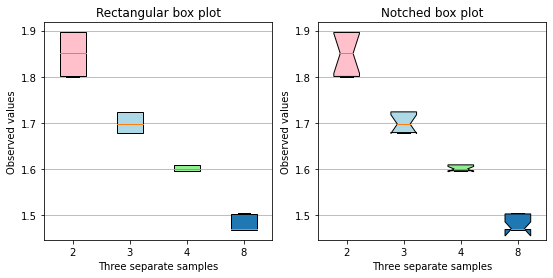

In [12]:
import matplotlib.pyplot as plt
import numpy as np


# r= {0.0007: [1.8962629124977626, 1.7239882029844498, 1.6089779539576528, 1.4681648514608552, 1.896480486783705, 1.7243868541167449, 1.6092665684873428, 1.4682749740849188, 1.896256178668206, 1.7239275780422287, 1.6091976907844414, 1.4679255368627417, 1.8959803400411601, 1.723826288076145, 1.608975335941946, 1.468930418778976], 0.001: [1.850202494981479, 1.6973675066418445, 1.595436754372912, 1.4700986738837654, 1.8505385473472078, 1.6972962666544136, 1.5962447933024317, 1.4700810001217552, 1.8506694703450683, 1.6976147903436911, 1.5961544800750154, 1.472021334470938, 1.850919706609337, 1.6973601392634514, 1.5958352455077027, 1.4700194036212053], 0.003: [1.8005364250011835, 1.6773807149581863, 1.60014852941341, 1.5025550599673736, 1.8001742035508146, 1.6775618514316089, 1.5986150593305195, 1.5039375399695205, 1.8007124482735408, 1.6782787464453222, 1.599383160456623, 1.5026751528360311, 1.7988711982144054, 1.6792336569678512, 1.6011629333731188, 1.5032627131200094]}
# r={0: [1.8962629124977626, 1.7239882029844498, 1.6089779539576528, 1.4681648514608552, 1.850202494981479, 1.6973675066418445, 1.595436754372912, 1.4700986738837654, 1.8005364250011835, 1.6773807149581863, 1.60014852941341, 1.5025550599673736], 0.0007: [1.896480486783705, 1.7243868541167449, 1.6092665684873428, 1.4682749740849188, 1.8505385473472078, 1.6972962666544136, 1.5962447933024317, 1.4700810001217552, 1.8001742035508146, 1.6775618514316089, 1.5986150593305195, 1.5039375399695205], 0.001: [1.896256178668206, 1.7239275780422287, 1.6091976907844414, 1.4679255368627417, 1.8506694703450683, 1.6976147903436911, 1.5961544800750154, 1.472021334470938, 1.8007124482735408, 1.6782787464453222, 1.599383160456623, 1.5026751528360311], 0.003: [1.8959803400411601, 1.723826288076145, 1.608975335941946, 1.468930418778976, 1.850919706609337, 1.6973601392634514, 1.5958352455077027, 1.4700194036212053, 1.7988711982144054, 1.6792336569678512, 1.6011629333731188, 1.5032627131200094]}
r = {2: [1.8962629124977626, 1.896480486783705, 1.896256178668206, 1.8959803400411601, 1.850202494981479, 1.8505385473472078, 1.8506694703450683, 1.850919706609337, 1.8005364250011835, 1.8001742035508146, 1.8007124482735408, 1.7988711982144054], 3: [1.7239882029844498, 1.7243868541167449, 1.7239275780422287, 1.723826288076145, 1.6973675066418445, 1.6972962666544136, 1.6976147903436911, 1.6973601392634514, 1.6773807149581863, 1.6775618514316089, 1.6782787464453222, 1.6792336569678512], 4: [1.6089779539576528, 1.6092665684873428, 1.6091976907844414, 1.608975335941946, 1.595436754372912, 1.5962447933024317, 1.5961544800750154, 1.5958352455077027, 1.60014852941341, 1.5986150593305195, 1.599383160456623, 1.6011629333731188], 8: [1.4681648514608552, 1.4682749740849188, 1.4679255368627417, 1.468930418778976, 1.4700986738837654, 1.4700810001217552, 1.472021334470938, 1.4700194036212053, 1.5025550599673736, 1.5039375399695205, 1.5026751528360311, 1.5032627131200094]}
us = []
lu = []
for i in r:
    u = []
    for j in r[i]:
        u.append(j)
    us.append(u)
    lu.append(i)


# Random test data
np.random.seed(19680801)
all_data = us
labels = lu

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = axes[0].boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[0].set_title('Rectangular box plot')

# notch shape box plot
bplot2 = axes[1].boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[1].set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()

In [ ]:
start = time.time()

all_users_predict, all_items_predict, users_items_array_to_predict = readFile("fold/targets-0.csv", type="train",
                                                                                  type_return="array")
all_users_train, all_items_train, users_items_map_train = readFile("fold/ratings-0.csv", type="train")

y_true = []
for i in range(len(users_items_array_to_predict)):
    y_true.append(users_items_array_to_predict[i][2])
y_true = np.array(y_true)


indexes_users, users_without_rating = indexTwoSets(all_users_train, all_users_predict)
indexes_items, _ = indexTwoSets(all_items_predict, all_items_train)

end = time.time()
print("Elapsed Time To Read and Index: %.2fs" % (end - start))
best_comb = 99999999999
bla = []
for num_latent_factor in [2, 5, 10, 24, 48]:
    for alpha in [0.1, 0.01, 0.001, 0.0001]:
        for lambda_reg in [0.01, 0.001, 0.0001, 0.0005]:
            for type_of_pred in [1, 2, 3]:
                t1 = time.time()
                model = SVD(num_iteracoes=20, num_latent_factor=num_latent_factor, alpha=alpha, lambda_reg=lambda_reg)
                # model = SVD(num_iteracoes=2, num_latent_factor=num_latent_factor, alpha=alpha)
                model.fit(users_items_map_train, indexes_users, indexes_items)

                predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)
                
                if type_of_pred == 1:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items, users_without_rating, type_of_predict_for_users_without_rating='mean_item')
                elif type_of_pred == 2:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items, users_without_rating, type_of_predict_for_users_without_rating='global_mean')
                else:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)

                predicts = np.array(predicts)
                rmse = np.nan_to_num(np.sqrt(np.mean((y_true - predicts) ** 2)))
                if rmse == 0:
                    rmse = 99999999999
                t2 = time.time()
                t3 = t2 - t1
                print("---------------------------")
                print(f"alpha: {alpha} ---- latentf: {num_latent_factor} ---- time: {t3}s")
                print(f"rmse: {rmse}")
                if rmse < best_comb:
                    best_comb = rmse
                    bla = []
                    bla.append(num_latent_factor)
                    bla.append(alpha)
                    bla.append(lambda_reg)
                    bla.append(type_of_pred)
print("--------FINAL------")
print(best_comb)
print(bla)


Elapsed Time To Read and Index: 1.11s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:364: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:348: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:364: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:402: RuntimeWarning: overflow encountered in matmul
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in square


---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.764319658279419s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.7064437866210938s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 4.115528345108032s
rmse: 1.7976931348623157e+308
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.727811574935913s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.605473279953003s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.6094021797180176s
rmse: 1.7976931348623157e+308
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.6291263103485107s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.581017017364502s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 2 ---- time: 3.596412420272827s
rmse: 1.7976931348623157e+308
---------------------------
alpha:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:356: RuntimeWarning: overflow encountered in multiply


---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.654010772705078s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.617905378341675s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.616089105606079s
rmse: 1.7976931348623157e+308


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:356: RuntimeWarning: invalid value encountered in add


---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6397476196289062s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6319503784179688s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6719911098480225s
rmse: 1.7976931348623157e+308
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6395633220672607s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6344738006591797s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.651766777038574s
rmse: 1.7976931348623157e+308
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6351318359375s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.625436782836914s
rmse: 99999999999
---------------------------
alpha: 0.1 ---- latentf: 5 ---- time: 3.6208176612854004s
rmse: 1.7976931348623157e+308
---------------------------
alpha

KeyboardInterrupt: ignored

In [ ]:
start = time.time()

all_users_predict, all_items_predict, users_items_array_to_predict = readFile("fold/targets-2.csv", type="train",
                                                                                  type_return="array")
all_users_train, all_items_train, users_items_map_train = readFile("fold/ratings-2.csv", type="train")

y_true = []
for i in range(len(users_items_array_to_predict)):
    y_true.append(users_items_array_to_predict[i][2])
y_true = np.array(y_true)


indexes_users, users_without_rating = indexTwoSets(all_users_train, all_users_predict)
indexes_items, _ = indexTwoSets(all_items_predict, all_items_train)

end = time.time()
print("Elapsed Time To Read and Index: %.2fs" % (end - start))
best_comb = 99999999999
bla = []
for num_latent_factor in [2, 5, 10, 24, 48]:
    for alpha in [0.1, 0.01, 0.001, 0.0001]:
        for lambda_reg in [0.01, 0.001, 0.0001, 0.0005]:
            for type_of_pred in [1, 2, 3]:
                t1 = time.time()
                model = SVD(num_iteracoes=20, num_latent_factor=num_latent_factor, alpha=alpha, lambda_reg=lambda_reg)
                # model = SVD(num_iteracoes=2, num_latent_factor=num_latent_factor, alpha=alpha)
                model.fit(users_items_map_train, indexes_users, indexes_items)

                predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)
                
                if type_of_pred == 1:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items, users_without_rating, type_of_predict_for_users_without_rating='mean_item')
                elif type_of_pred == 2:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items, users_without_rating, type_of_predict_for_users_without_rating='global_mean')
                else:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)

                predicts = np.array(predicts)
                rmse = np.nan_to_num(np.sqrt(np.mean((y_true - predicts) ** 2)))
                if rmse == 0:
                    rmse = 99999999999
                t2 = time.time()
                t3 = t2 - t1
                print("---------------------------")
                print(f"alpha: {alpha} ---- latentf: {num_latent_factor} ---- time: {t3}s")
                print(f"rmse: {rmse}")
                if rmse < best_comb:
                    best_comb = rmse
                    bla = []
                    bla.append(num_latent_factor)
                    bla.append(alpha)
                    bla.append(lambda_reg)
                    bla.append(type_of_pred)
print("--------FINAL------")
print(best_comb)
print(bla)


In [ ]:
start = time.time()

all_users_predict, all_items_predict, users_items_array_to_predict = readFile("fold/targets-1.csv", type="train",
                                                                                  type_return="array")
all_users_train, all_items_train, users_items_map_train = readFile("fold/ratings-1.csv", type="train")

y_true = []
for i in range(len(users_items_array_to_predict)):
    y_true.append(users_items_array_to_predict[i][2])
y_true = np.array(y_true)


indexes_users, users_without_rating = indexTwoSets(all_users_train, all_users_predict)
indexes_items, _ = indexTwoSets(all_items_predict, all_items_train)

end = time.time()
print("Elapsed Time To Read and Index: %.2fs" % (end - start))
best_comb = 99999999999
bla = []
for num_latent_factor in [2, 5, 10, 24, 48]:
    for alpha in [0.1, 0.01, 0.001, 0.0001]:
        for lambda_reg in [0.01, 0.001, 0.0001, 0.0005]:
            for type_of_pred in [1, 2, 3]:
                t1 = time.time()
                model = SVD(num_iteracoes=20, num_latent_factor=num_latent_factor, alpha=alpha, lambda_reg=lambda_reg)
                # model = SVD(num_iteracoes=2, num_latent_factor=num_latent_factor, alpha=alpha)
                model.fit(users_items_map_train, indexes_users, indexes_items)

                predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)
                
                if type_of_pred == 1:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items, users_without_rating, type_of_predict_for_users_without_rating='mean_item')
                elif type_of_pred == 2:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items, users_without_rating, type_of_predict_for_users_without_rating='global_mean')
                else:
                    predicts = model.predict(users_items_array_to_predict, indexes_users, indexes_items)

                predicts = np.array(predicts)
                rmse = np.nan_to_num(np.sqrt(np.mean((y_true - predicts) ** 2)))
                if rmse == 0:
                    rmse = 99999999999
                t2 = time.time()
                t3 = t2 - t1
                print("---------------------------")
                print(f"alpha: {alpha} ---- latentf: {num_latent_factor} ---- time: {t3}s")
                print(f"rmse: {rmse}")
                if rmse < best_comb:
                    best_comb = rmse
                    bla = []
                    bla.append(num_latent_factor)
                    bla.append(alpha)
                    bla.append(lambda_reg)
                    bla.append(type_of_pred)
print("--------FINAL------")
print(best_comb)
print(bla)
